# Utils

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_auc_score, roc_curve

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 240
mpl.rcParams["figure.facecolor"] = 'white'
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)

In [35]:
# Taken from https://github.com/Big-Life-Lab/partial-AUC-C/blob/main/Python3.7/do_pAUCc.py
def concordant_partial_AUC(pfpr, ptpr):
    ''' Computes the concordant partial area under the curve and alternatives, given arrays of \n
    "partial fpr" and "partial tpr" values.  These arrays only contain points on the partial curve \n
    and the trapezoidal rule is used to compute areas with these points. \n
    \n
    pAUCc:      the concordant partial area under the curve \n
    pAUC:       the (vertical) partial area under the curve \n
    pAUCx:      the horizontal partial area under the curve \n
    pAUCc_norm: the concordant partial area under the curve normalized \n
    pAUC_norm:  the (vertical) partial area under the curve normalized \n
    pAUCx_norm: the horizontal partial area under the curve normalized \n
    '''

    # xrange [a,b]
    a    = float(pfpr[0])
    b    = float(pfpr[-1])
    delx = b - a
    vertical_stripe_area = (1 * delx)

    # yrange [f,g]
    f    = float(ptpr[0])
    g    = float(ptpr[-1])
    dely = g - f
    horizontal_stripe_area = (dely * 1)

    if delx == 0:
        print("Warning: For pAUC and pAUCc the width (delx) of the vertical column is zero.")
        pAUC  = 0
        pAUCn = 0
        sPA   = 0
    else:
        # Compute the partial AUC mathematically defined in (Dodd and Pepe, 2003) and conceptually defined in
        #   (McClish, 1989; Thompson and Zucchini, 1989). Use the trapezoidal rule to compute the integral.
        pAUC  = np.trapz(ptpr, pfpr)  # trapz is y,x
        pAUCn = pAUC / vertical_stripe_area
    #endif

    if dely == 0:
        print("Warning: For pAUCx and pAUCc the height (dely) of the horizontal stripe is zero.")
        pAUCx  = 0
        pAUCxn = 0
    else:
        # Compute the horizontal partial AUC (pAUCx) defined in (Carrington et al, 2020) and as
        # suggested by (Walter, 2005) and similar to the partial area index (PAI)
        # (Nishikawa et al, ?) although PAI has a fixed right boundary instead and a slightly
        # different mathematical definition.
        #
        # Normally we would compute the area to the right of the curve, the horizontal integral,
        # as follows:
        #   1. swap the axes
        #   2. flip the direction of the new vertical
        #   3. compute the (vertical) integral
        #
        tempX  = ptpr                      # swap the axes
        tempY  = list(1 - np.array(pfpr))  # flip the direction
        pAUCx  = np.trapz(tempY, tempX)    # trapz is y,x
        pAUCxn = pAUCx / horizontal_stripe_area
    #endif

    total_for_norm = vertical_stripe_area + horizontal_stripe_area
    if total_for_norm == 0:
        pAUCc  = 0
        pAUCcn = 0
        print('Warning: Zero length partial curve specified.')
    else:
        pAUCc  = (1/2)*pAUCx + (1/2)*pAUC  # the complexity is in the derivation, meaning/generalization
        #   and relation to the c and partial c statistic, not the
        #   formula which looks like a simple average
        #pAUCcn= (pAUCx + pAUC) / total_for_norm
        if vertical_stripe_area > 0 and horizontal_stripe_area > 0: # NEW part-wise normalization
            pAUCcn = (1 / 2) * (pAUC  / vertical_stripe_area) + (1 / 2) * (pAUCx / horizontal_stripe_area)
        elif pAUCn == 1:
            pAUCcn = 1 # best case scenario
        elif vertical_stripe_area   == 0:
            pAUCcn = (1 / 2) * (pAUCx / horizontal_stripe_area)
        elif horizontal_stripe_area == 0:
            pAUCcn = (1 / 2) * (pAUC  / vertical_stripe_area)
        # endif
    #endif
    
    sPA = 0.5*(1+ (pAUC - (pfpr[-1]**2)/2)/ (pfpr[-1] - (pfpr[-1]**2)/2))  # One the use of partial AUC. Hua Ma et all
    
    return pAUCc, pAUC, pAUCx, pAUCcn, pAUCn, pAUCxn, sPA

In [36]:
# https://github.com/Big-Life-Lab/partial-AUC-C/blob/main/Python3.7/do_pAUCc.py#L284
def standardized_partial_area_proxy(pfpr, ptpr):
    # this is not the full binormal curve fit version of McClish's sPA
    # it is instead a proxy for that using a simpler definition
    '''
    sPA:        the (vertical) partial area standardized, subtracts trapezoid below major diagonal
    '''
    # xrange [a,b]
    a    = float(pfpr[0])
    b    = float(pfpr[-1])
    delx = b - a
    vertical_stripe_area = (1 * delx)

    # yrange [f,g]
    f    = float(ptpr[0])
    g    = float(ptpr[-1])
    dely = g - f
    horizontal_stripe_area = (dely * 1)

    if delx == 0:
        print("Warning: For sPA the width of the region is zero.")
        sPA   = 0
    else:
        # Compute the standardized partial area (sPA) defined in (McClish, 2006), with a correction.
        # McClish calls Atrapezoid: Amin, but McClish erroneously swapped the Amin & Amax formulas
        # McClish calls Acolumn:    Amax

        sPA_rescale = lambda x: 0.5 * (1 + x)  # sPA rescales [0,1] to [0.5,1]
        pAUC        = np.trapz(ptpr, pfpr)  # trapz is y,x
        Atrapezoid  = (0.5 * (a + b)) * (b - a)  # average height of trap  * width
        Acolumn     =               1 * (b - a)  #                       1 * width
        sPA         = sPA_rescale( (pAUC-Atrapezoid)/(Acolumn-Atrapezoid) )
    #endif
    return sPA

# Simulate Metrics

In [37]:
fpr_sim = np.linspace(0, 1, 100)

In [51]:
fpr_cutoff=0.1
idx = np.where(fpr_sim>=fpr_cutoff)[0].min()
idx=idx+1

In [52]:
def sim_tpr(fpr_ar, i):
    if i==0:
        return fpr_ar # random classifier
    elif i==250:
        return [1]*len(fpr_ar) # perfect classifier
    elif i==-250:
        return [0]*len(fpr_ar) # completely wrong classifier
    elif i < -1:
        return [min(j, 1) for j in fpr_sim*(1/np.exp(-i*(1-fpr_sim)))] # bad classifier
    else:
        return 1-((1-fpr_sim)/np.exp(fpr_sim*i))  # inverse expontial

In [53]:
K = [
    -250, 
    -199, -197, -193, -191, -181, -179, -173, -167, -163, -157, 
    -151, -149, -139, -137, -131, -127, -113, -109, -107, -103, -101,
    -97,  -89,  -83,  -79,  -73,  -71,  -67,  -61,  -59,  -53,  -47,
    -43,  -41,  -37,  -31,  -29,  -23,  -19,  -17,  -11,   -7,   -5,
    -3,   -2,   -1,  # negative models
   
    0,
    1,2,3,5,7,11,17,19,23,29,31,37,41,43,47,53,59,61,67,71,73,79,83,89,97, 
    101,103,107,109,113,127,131,137,139,149,151,157,163,167,173,179,181,191,193,197,199,
    250
]

In [54]:
sim_metrics = {}
sim_metrics['auc'] = []
sim_metrics['K'] = K
sim_metrics['pAUCn'] = []
sim_metrics['pAUCcn'] = []
sim_metrics['sPA'] = []

In [55]:
for i in K:
    tpr_sim = sim_tpr(fpr_sim, i)
    pAUCc, pAUC, pAUCx, pAUCcn, pAUCn, pAUCxn, _ = concordant_partial_AUC(fpr_sim[:idx], tpr_sim[:idx])
    sPA = standardized_partial_area_proxy(fpr_sim[:idx], tpr_sim[:idx])
    
    sim_metrics['auc'].append(auc(fpr_sim, tpr_sim))
    sim_metrics['pAUCn'].append(pAUCn)
    sim_metrics['pAUCcn'].append(pAUCcn)
    sim_metrics['sPA'].append(sPA)

In [56]:
sim_metrics_df = pd.DataFrame(sim_metrics)

In [57]:
sim_metrics_df.tail()

,auc,K,pAUCn,pAUCcn,sPA
90,0.993253,191,0.933207,0.963230,0.964827
91,0.993293,193,0.933598,0.963446,0.965033
92,0.993369,197,0.934349,0.963859,0.965429
93,0.993405,199,0.934710,0.964058,0.965619
94,1.000000,250,1.000000,1.000000,1.000000


In [60]:
sim_metrics_df.head()

,auc,K,pAUCn,pAUCcn,sPA
0,0.000000,-250,0.000000e+00,0.000000,0.473404
1,0.006595,-199,1.298822e-80,0.452711,0.473404
2,0.006631,-197,7.880674e-80,0.452727,0.473404
3,0.006707,-193,2.902202e-78,0.452761,0.473404
4,0.006747,-191,1.761490e-77,0.452778,0.473404


In [58]:
sim_metrics_df[sim_metrics_df.K==0]

,auc,K,pAUCn,pAUCcn,sPA
47,0.5,0,0.050505,0.5,0.5


Text(0.5, 1.0, 'Range of area under curve metrics for wrong, poor to good classifers')

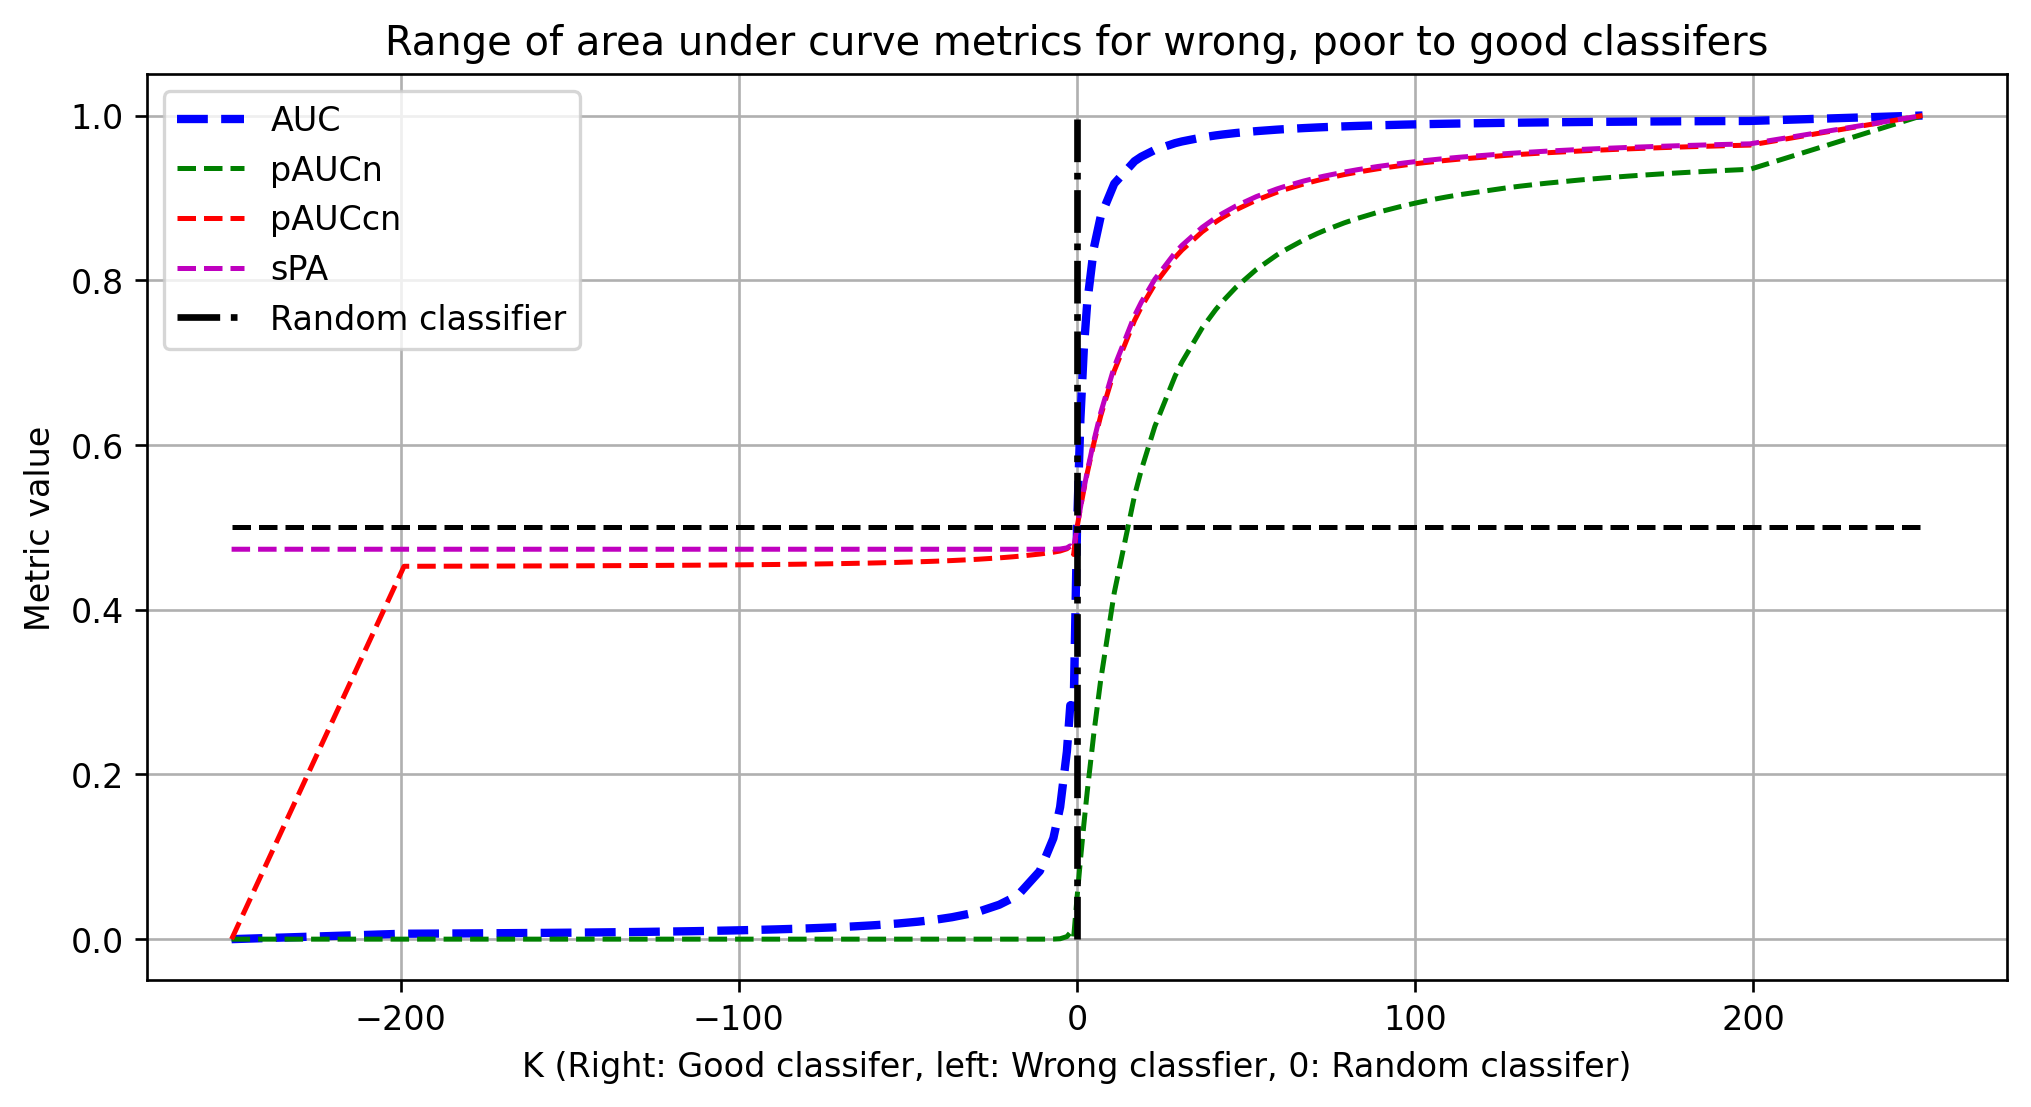

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.plot(sim_metrics_df['K'], sim_metrics_df['auc'], '--', color='b', label='AUC', linewidth=2.5)
ax.plot(sim_metrics_df['K'], sim_metrics_df['pAUCn'], '--', color='g', label='pAUCn')
ax.plot(sim_metrics_df['K'], sim_metrics_df['pAUCcn'], '--', color='r', label='pAUCcn')
ax.plot(sim_metrics_df['K'], sim_metrics_df['sPA'], '--', color='m', label='sPA')

ax.hlines(0.5, sim_metrics_df['K'].min(), sim_metrics_df['K'].max(), linestyle='--', color='k')
ax.vlines(0.0, 0, 1 , linestyle='-.', linewidth=2, color='k', label='Random classifier')

ax.set_ylabel('Metric value')
ax.set_xlabel('K (Right: Good classifer, left: Wrong classfier, 0: Random classifer)')
ax.grid()
ax.legend()

ax.set_title('Range of area under curve metrics for wrong, poor to good classifers')

# End